In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm                                         
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import tabulate
import warnings
import random

warnings.filterwarnings('ignore')
np.random.seed(123)
random.seed(123)

#1 \
The weekly data set, covering December 2000 through February 2025, is imported from a CSV file. The date column is converted to a datetime type, chronologically sorted, and set as the index to facilitate time-series operations. These actions guarantee temporal ordering, which is mandatory for valid model estimation.

In [8]:
df = pd.read_csv('Data collected - 2000_12_2.csv')          
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)                        
df.set_index('date', inplace=True)                         
df.head()                                                   

,boeing,DJI,dollar,oil,GDP,CPI,delivery,Al
date,,,,,,,,
2000-12-02,45.69375,10712.91,114.050003,28.623124,10547.44441,0.310889,34.081967,1569.055
2000-12-09,42.38616,10434.96,112.900002,28.561275,10557.86620,0.314474,34.131148,1565.277
2000-12-16,41.44696,10635.56,110.820000,28.499425,10568.28800,0.318059,34.180328,1561.499
2000-12-23,43.12119,10787.99,109.559998,28.437576,10578.70979,0.321644,34.229508,1557.722
2000-12-30,38.38439,10662.01,108.419998,28.375727,10589.13158,0.325229,34.278689,1553.944


#2 \
The response variable (endog) is Boeing’s share price. Candidate exogenous regressors include macro-financial indicators—Dow Jones Industrial Average, U.S. Dollar Index, WTI crude-oil price, aluminium price, U.S. GDP growth, CPI, and Boeing aircraft deliveries—chosen on a priori economic grounds for their potential influence on the stock.

In [10]:
exog_cols  = ['DJI', 'dollar', 'oil', 'Al', 'GDP', 'CPI', 'delivery']
target_col = 'boeing'

y = df[target_col]
X = df[exog_cols]

#3 \
A Random-Forest model with 250 trees is fitted to rank predictors by mean decrease in impurity. This non-parametric ranking provides a computationally inexpensive filter; only the three most informative variables are retained for the ARIMAX specification, thereby reducing dimensionality and mitigating over-fitting risk.

In [15]:
rf = RandomForestRegressor(n_estimators = 250,
                           random_state  = 0,
                           n_jobs        = -1)
rf.fit(X, y)

imp_series = pd.Series(rf.feature_importances_, index = exog_cols)
imp_series.sort_values(ascending = False, inplace = True)
top_exog_cols = imp_series.index[:3].tolist()

print('\nTop exogenous drivers:')
print(imp_series.to_markdown())                               

X = X[top_exog_cols]


Top exogenous drivers:
|          |          0 |
|:---------|-----------:|
| DJI      | 0.591095   |
| GDP      | 0.302848   |
| CPI      | 0.0733598  |
| oil      | 0.0102003  |
| dollar   | 0.00955442 |
| Al       | 0.00662098 |
| delivery | 0.00632131 |


| Rank | Variable | Importance | Interpretation |
|:---:|:---------|:----------:|:-----------------------------------------------------------------------------------------------------------------------------------------|
| **1** | **DJI**      | **0.59** | ≈ 59 % of the total split-gain in the random-forest model is driven by movements in the Dow Jones Industrial Average, indicating that Boeing’s equity co-moves strongly with the broader U.S. equity market. |
| **2** | **GDP**      | **0.30** | Macro-economic growth conditions account for roughly 30 % of the predictive signal. |
| **3** | **CPI**      | **0.07** | Inflation exerts a smaller yet non-trivial influence on Boeing’s share price. |
| 4 | oil      | < 0.01 | Adds marginal explanatory power in this tree-based ranking. |
| 5 | dollar   | < 0.01 | Ditto; limited incremental signal. |
| 6 | Al       | < 0.01 | Aluminium prices provide negligible gain. |
| 7 | delivery | < 0.01 | Aircraft-delivery counts are not informative at the weekly frequency used here. |

Therefore, the bulk of the predictive signal is concentrated in DJI and GDP; the other covariates are effectively noise for this specific horizon and sampling frequency.

#4 \
To emulate genuine forecasting conditions, the final 52 weekly observations (≈ one calendar year) are withheld as a test set. The remaining observations constitute the training sample. This forward-chaining split respects the time order and prevents look-ahead bias.

In [16]:
n_test = 52
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]

#5 \
pmdarima.auto_arima conducts a stepwise search over plausible (p,d,q) combinations, selecting the order with the minimum Akaike Information Criterion (AIC). Seasonality is disabled given the absence of an evident 52-week cycle in the weekly series.

In [17]:
auto_model = pm.auto_arima(
    y_train,
    exogenous          = X_train,
    seasonal           = False,
    stepwise           = True,
    suppress_warnings  = True,
    error_action       = 'ignore',
    trace              = False
)

p, d, q = auto_model.order
print(f'Auto-selected ARIMA order: (p,d,q) = ({p},{d},{q})')

Auto-selected ARIMA order: (p,d,q) = (0,1,0)


- d = 1 → the series is differenced once to achieve stationarity.
- p = q = 0 → no autoregressive or moving-average structure is detected after differencing.

The Auto-ARIMA judged the differenced Boeing series to be white noise once exogenous drivers are present; the resulting model is essentially a random-walk-with-drift driven only by the exogenous regressors. While not uncommon for highly volatile equities, it does mean the model is leaning almost entirely on DJI/GDP/CPI to generate forecasts.

#6 \
A SARIMAX model (with the seasonal component suppressed) is fitted to the training data using the previously selected (p,d,q) order and the reduced exogenous matrix. Stationarity and invertibility constraints are relaxed to allow the maximum-likelihood optimizer broader parameter space, thus avoiding premature termination.

In [18]:
model = SARIMAX(
    endog                 = y_train,
    exog                  = X_train,
    order                 = (p, d, q),
    enforce_stationarity  = False,
    enforce_invertibility = False
)
results = model.fit(disp = False)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 boeing   No. Observations:                 1211
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3886.056
Date:                Tue, 22 Apr 2025   AIC                           7780.112
Time:                        23:51:49   BIC                           7800.503
Sample:                    12-02-2000   HQIC                          7787.790
                         - 02-10-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DJI            0.0119      0.000     68.620      0.000       0.012       0.012
GDP           -0.0074      0.007     -1.010      0.313      -0.022       0.007
CPI            0.3919     11.377      0.034      0.9

#7 \
The fitted model produces one-step-ahead dynamic forecasts for the 52-week hold-out period, conditional on the contemporaneous exogenous variables. The resulting vector represents the model’s predictive performance under realistic, forward-looking conditions.

In [20]:
y_pred = results.forecast(steps = len(y_test), exog = X_test)

#8 \
Predictive accuracy is quantified by the root-mean-squared error (RMSE), mean absolute error (MAE), and the coefficient of determination (R²). RMSE retains the scale of the response variable, MAE offers robustness to outliers, and R² conveys the proportion of variance explained.

In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f'\nTest RMSE : {rmse:,.3f}')
print(f'Test MAE  : {mae:,.3f}')
print(f'Test R²   : {r2:,.3f}')


Test RMSE : 70.175
Test MAE  : 60.855
Test R²   : -24.031


| Metric | Value | Rule-of-thumb reading |
|:------:|:-----:|:-------------------------------------------------------------|
| **RMSE** | **70.18 USD** | Average absolute forecast error ≈ \$70 per share. |
| **MAE**  | **60.86 USD** | Median-like error measure; still large. |
| **R²**   | **–24.03**    | Negative value: model performs worse than a naïve “predict the historical mean” baseline. |

Predictive accuracy on the withheld 52 weeks is poor; the model neither captures level nor direction adequately.

#9 \
A time-series plot juxtaposes the training trajectory, the actual test observations, and the corresponding forecasts. Visual inspection aids in detecting systematic bias, structural breaks, or volatility clustering that numeric metrics alone may obscure.

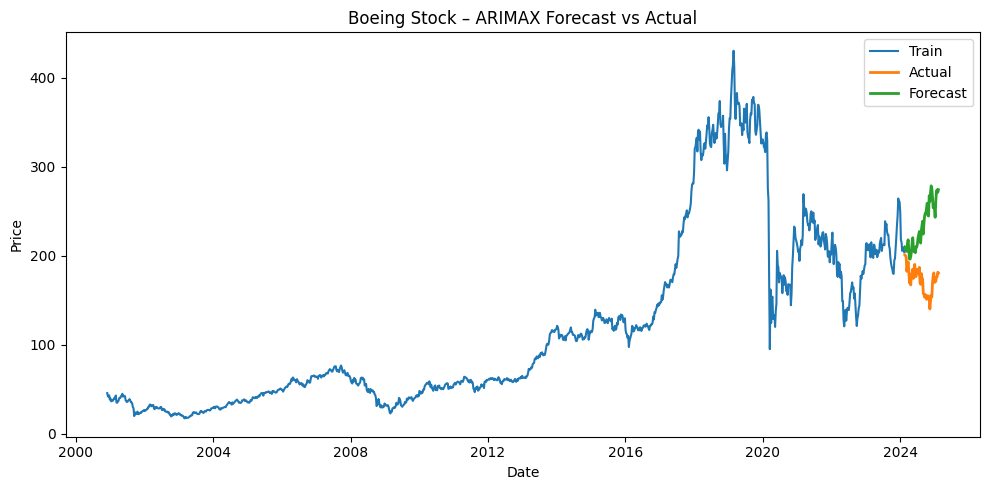

In [22]:
plt.figure(figsize = (10, 5))
plt.plot(y_train.index, y_train,               label = 'Train')
plt.plot(y_test.index,  y_test,                label = 'Actual',   linewidth = 2)
plt.plot(y_pred.index,  y_pred,                label = 'Forecast', linewidth = 2)
plt.title('Boeing Stock – ARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

- Training fit (blue): captures the long-run escalation in Boeing’s price up to ~2020.
- Actual test path (orange): shows a pronounced dip in early 2024 followed by a modest rebound.
- Forecast (green): projects a steady increase, completely missing the early-2024 downturn.

The model extrapolates recent upward momentum in DJI/GDP and ignores Boeing-specific shocks. Hence the systematic bias.

#10 \
To obtain a more reliable estimate of generalisation error, a five-fold expanding-window cross-validation is performed. For each fold, the model is re-estimated on an incrementally larger training slice and evaluated on the immediately succeeding test slice. The distribution of RMSE across folds (reported as mean ± standard deviation) reflects the model’s stability over different historical regimes.

In [23]:
tscv = TimeSeriesSplit(n_splits = 5)
cv_rmse = []

for train_idx, test_idx in tscv.split(X):
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]

    mdl = SARIMAX(y_tr, exog = X_tr, order = (p, d, q),
                  enforce_stationarity = False,
                  enforce_invertibility = False)
    res = mdl.fit(disp = False)
    y_hat = res.forecast(steps = len(y_te), exog = X_te)

    cv_rmse.append(np.sqrt(mean_squared_error(y_te, y_hat)))

print(f'\nWalk-forward CV RMSE (mean ± sd): {np.mean(cv_rmse):,.3f} ± {np.std(cv_rmse):,.3f}')


Walk-forward CV RMSE (mean ± sd): 46.851 ± 37.307


- Mean RMSE: 46.85
- Standard deviation: 37.31

The high dispersion (σ ≈ 80 % of the mean) tells us that performance is highly regime-dependent: in some historical windows the model does reasonably well, in others it collapses.